# Machine Learning for Insurance: Customer Insights, Predictions, and Data Security

### Objective:
The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and you are asked to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

The Sure Tomorrow insurance company wants to explore how Machine Learning can help improve its business processes. The project involves evaluating the feasibility of solving several key tasks using ML models.

# Data Preprocessing & Exploration

## Initialization

In [3]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
import math

from IPython.display import display

## Load Data

Load data and conduct a basic check that it's free from obvious issues.

In [ ]:
df = pd.read_csv('/Users/keithrobinson/Desktop/TripleTen/Projects/project11/insurance_us.csv')

We rename the columns to make the code look more consistent with its style.

In [ ]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [ ]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
235,0,55.0,35900.0,1,3
916,1,41.0,55100.0,1,0
17,1,41.0,33200.0,2,0
1859,0,32.0,34900.0,2,0
2726,1,36.0,64000.0,3,0
211,0,33.0,39900.0,1,0
4145,1,28.0,37400.0,2,0
3356,1,20.0,46600.0,1,0
2149,1,20.0,47900.0,1,0
2699,0,40.0,39400.0,3,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [ ]:
# we may want to fix the age type (from float to int) though this is not critical
df['age'] = df['age'].astype(int)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [ ]:
# looking into the descriptive statistics
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


No negative numbers for any of the columns. Gender makes sense (1 or 0). Insurance benefits looks a tad odd but I already saw in the sample that Insurance benefits had nunbers other than 0 and 5.

In [ ]:
df.duplicated().sum()

153

In [ ]:
df.drop_duplicates(inplace=True, ignore_index=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4847 entries, 0 to 4846
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              4847 non-null   int64  
 1   age                 4847 non-null   int64  
 2   income              4847 non-null   float64
 3   family_members      4847 non-null   int64  
 4   insurance_benefits  4847 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 189.5 KB


The data is clean. It has the correct data types, no missing values and the duplicates were taken care of.

## EDA

I am going to check whether there are certain groups of customers by looking at the pair plot.

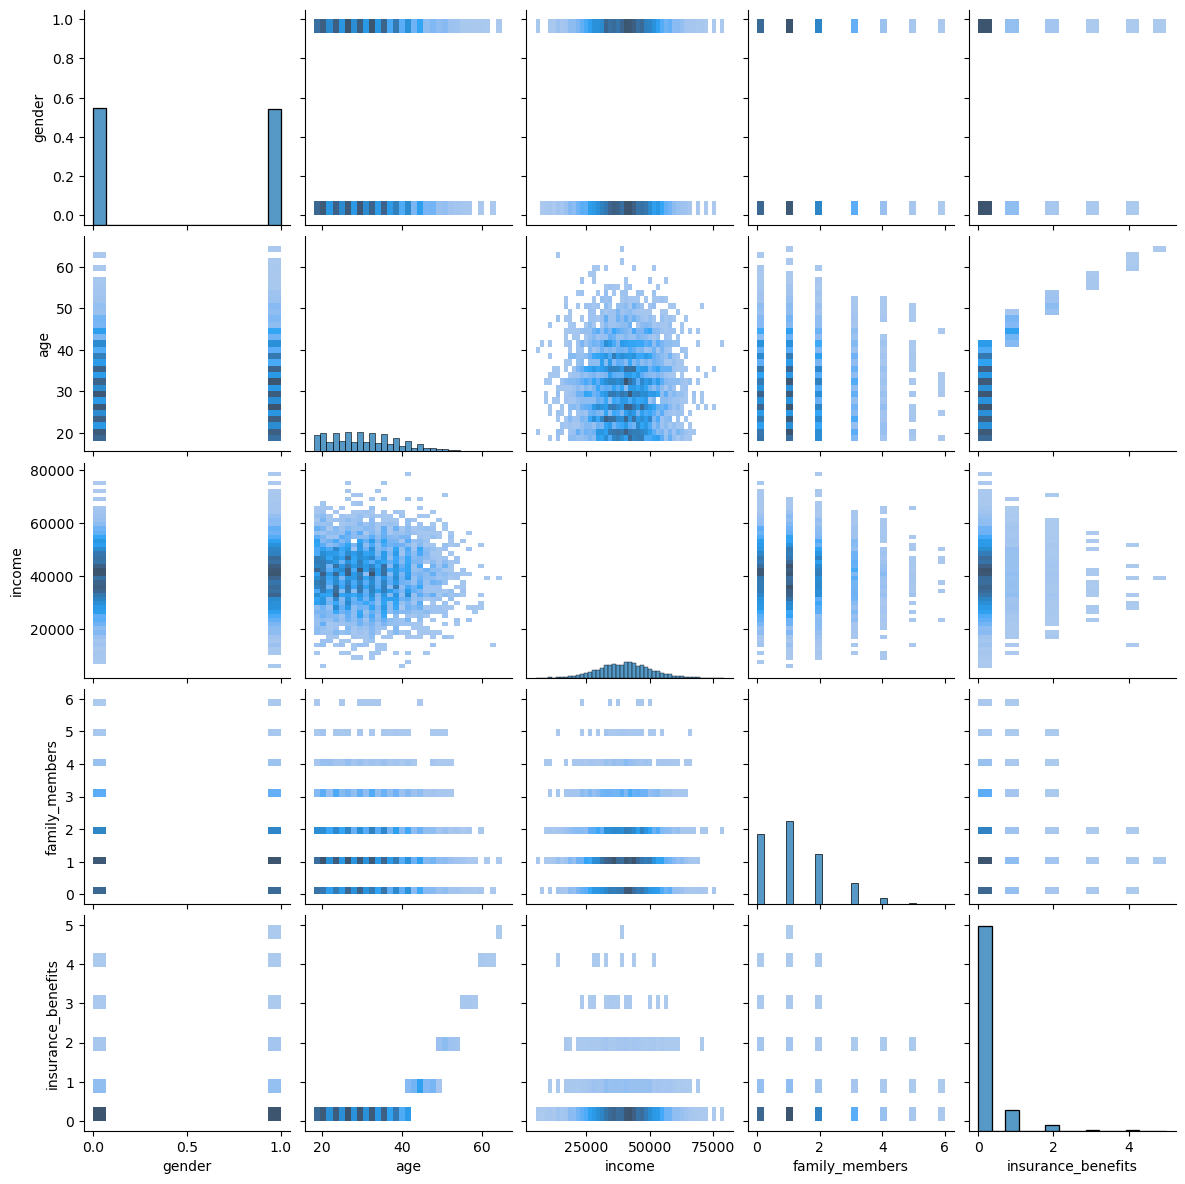

In [ ]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

Ok, it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions).

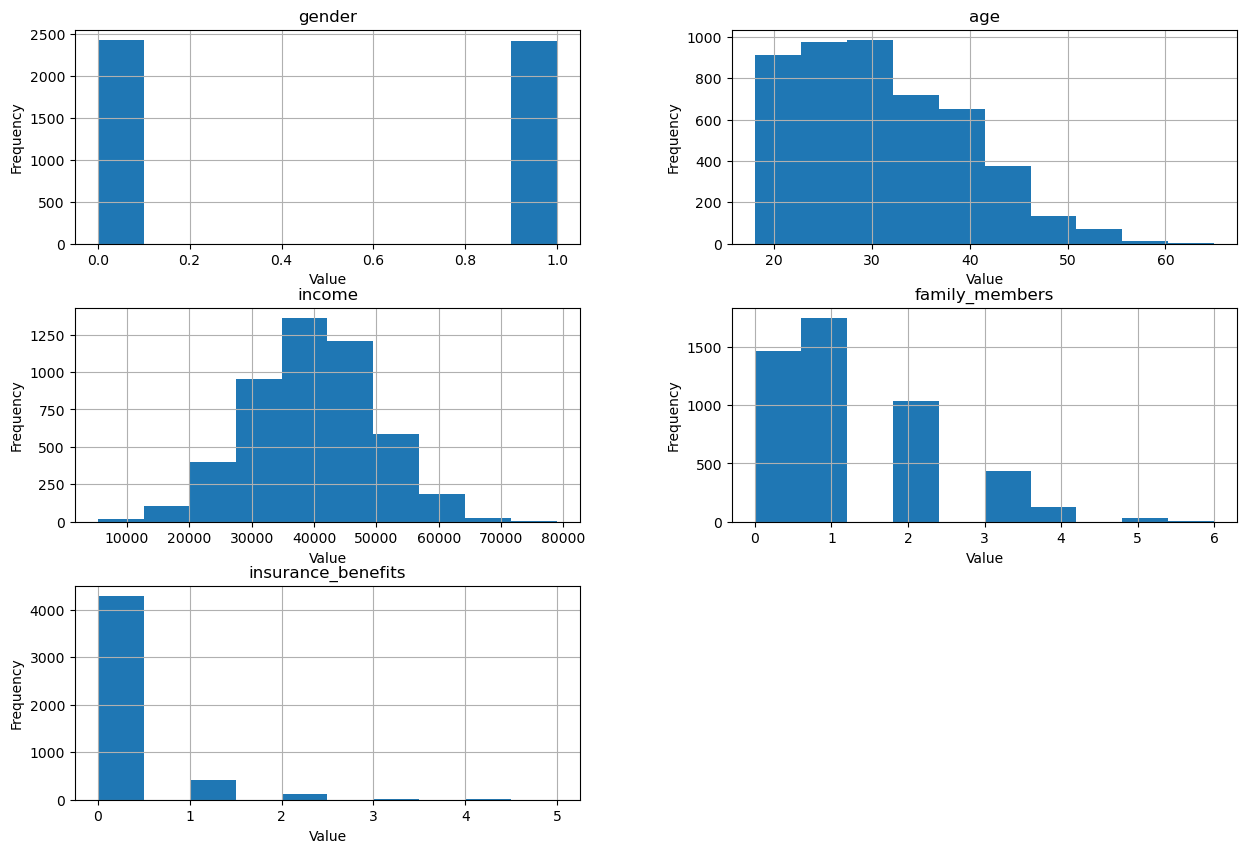

In [ ]:
ax = df.hist(figsize=(15,10))

for row in ax:
    for subplot in row:
        subplot.set_xlabel("Value") 
        subplot.set_ylabel("Frequency")
        
plt.show()

Looking at the histogram I can note a number of things:

* The amount of benefits received based on gender is pretty much the same between male and female
* Majority of the family members receiving benefits are between ages 20-30
* Insurance benefits are normally distributed around 40,000
* Most people have not received any insurance benefits whatsoever while a very small number of people have received at least 1 or more benefits


# Similar Customers

In the language of ML, it is necessary to develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

I am going to write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler
- Distance Metrics
  - Euclidean
  - Manhattan

Answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

In [ ]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [ ]:
def get_knn(df, n, k, metric, feature_names):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """

    nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=k, metric=metric)
    X = df[feature_names]
    nbrs.fit(X)
    test_sample = pd.DataFrame([df.iloc[n][feature_names]], columns=feature_names)
    nbrs_distances, nbrs_indices = nbrs.kneighbors(test_sample, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

Scaling the data.

In [ ]:
transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

/var/folders/2c/tfkhfg6d5jj1g3ttv18s3t5r0000gn/T/ipykernel_6990/44282885.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.63076923 0.70769231 0.44615385 ... 0.30769231 0.33846154 0.43076923]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())
/var/folders/2c/tfkhfg6d5jj1g3ttv18s3t5r0000gn/T/ipykernel_6990/44282885.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.16666667 0.16666667 0.         ... 0.33333333 0.5        0.16666667]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())


In [ ]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
1279,0,0.353846,0.607595,0.166667,0
3154,0,0.538462,0.287342,0.333333,0
3347,1,0.461538,0.569620,0.500000,0
773,1,0.476923,0.489873,0.166667,0
871,0,0.307692,0.597468,0.166667,0


Now, let's get similar records for a given one for every combination

In [ ]:
score_original_euclidean = get_knn(df, 42, 15, 'euclidean', feature_names)
score_original_euclidean

,gender,age,income,family_members,insurance_benefits,distance
42,1,42,69200.0,0,1,0.000000
4356,0,45,69400.0,1,1,200.027498
3914,0,33,68900.0,1,0,300.138301
2943,1,36,68500.0,1,0,700.026428
3667,1,28,70000.0,2,0,800.124990
2901,0,27,68400.0,0,0,800.141238
2056,1,21,68000.0,2,0,1200.185402
3279,1,50,70500.0,0,2,1300.024615
1863,1,30,70600.0,0,0,1400.051428
424,1,30,67700.0,0,0,1500.047999


In [ ]:
score_scaled_euclidean = get_knn(df_scaled, 42, 5, 'euclidean', feature_names)
score_scaled_euclidean

,gender,age,income,family_members,insurance_benefits,distance
42,1,0.646154,0.875949,0.0,1,0.000000
213,1,0.661538,0.763291,0.0,1,0.113704
3279,1,0.769231,0.892405,0.0,2,0.124172
771,1,0.600000,0.758228,0.0,0,0.126446
2833,1,0.630769,0.739241,0.0,0,0.137572


In [ ]:
score_original_manhattan = get_knn(df, 42, 15, 'manhattan', feature_names)
score_original_manhattan

,gender,age,income,family_members,insurance_benefits,distance
42,1,42,69200.0,0,1,0.0
4356,0,45,69400.0,1,1,205.0
3914,0,33,68900.0,1,0,311.0
2943,1,36,68500.0,1,0,707.0
3667,1,28,70000.0,2,0,816.0
2901,0,27,68400.0,0,0,816.0
2056,1,21,68000.0,2,0,1223.0
3279,1,50,70500.0,0,2,1308.0
1863,1,30,70600.0,0,0,1412.0
424,1,30,67700.0,0,0,1512.0


In [ ]:
score_scaled_manhattan = get_knn(df_scaled, 42, 5, 'manhattan', feature_names)
score_scaled_manhattan

,gender,age,income,family_members,insurance_benefits,distance
42,1,0.646154,0.875949,0.0,1,0.000000
213,1,0.661538,0.763291,0.0,1,0.128043
3279,1,0.769231,0.892405,0.0,2,0.139533
2833,1,0.630769,0.739241,0.0,0,0.152093
771,1,0.600000,0.758228,0.0,0,0.163875


**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

Data that is not scaled will affect the kNN algorithm. The kNN algorithm calculates the distance between entries based on feature values. If some features have significantly different scales—for example, the 'income' feature having a much larger scale than others—they will contribute more to the distance calculation. As a result, the model will give more weight to features with larger scales while potentially ignoring those with smaller scales.

**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

The results using different distance methods are very similar. I printed the top five vectors for both methods, and while the lists were identical, the order varied slightly due to small differences in distance.

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<h2>   Comment </h2>
    
* Manhattan distance is less sensitive to extreme outliers because it adds absolute differences linearly.
* Euclidean distance is more sensitive to outliers because it squares differences, giving more weight to large deviations.
</div>


# Is Customer Likely to Receive Insurance Benefit?

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

Instructions:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influence the evaluation metric, and whether scaling the data makes any difference. You can use a ready implemention of the kNN classification algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

In [ ]:
# calculate the target

df['insurance_benefits_received'] = df['insurance_benefits'].apply(lambda x: 0 if x == 0 else 1)
df.sample(10)

,gender,age,income,family_members,insurance_benefits,insurance_benefits_received
247,1,41,33800.0,1,0,0
1383,0,37,21700.0,1,0,0
282,1,37,45400.0,0,0,0
3263,1,22,38800.0,4,0,0
513,1,25,32800.0,3,0,0
4765,0,19,37700.0,1,0,0
120,1,24,46400.0,2,0,0
4394,0,28,48800.0,0,0,0
389,1,43,46400.0,2,1,1
3097,0,31,34300.0,2,0,0


In [ ]:
# checked for the class imbalance
df['insurance_benefits_received'].value_counts()

insurance_benefits_received
0    4284
1     563
Name: count, dtype: int64

In [ ]:
pos_class = df['insurance_benefits_received'].sum() / len(df)
pos_class

0.11615432226119249

The positive class is 11.6% of the entire dataset.

In [ ]:
# Splitting the original dataset
X = df.drop(['insurance_benefits', 'insurance_benefits_received'], axis=1)
y = df[['insurance_benefits_received']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scaling dataset
transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(X_train.to_numpy())
def max_abs_scaler(data):
    data_scaled = data.copy()
    data_scaled.loc[:, :] = transformer_mas.transform(data.to_numpy())
    return data_scaled
X_train_scaled = max_abs_scaler(X_train)
X_test_scaled = max_abs_scaler(X_test)

/var/folders/2c/tfkhfg6d5jj1g3ttv18s3t5r0000gn/T/ipykernel_6990/4287550827.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.62903226 0.59677419 0.32258065 ... 0.4516129  0.41935484 0.30645161]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_scaled.loc[:, :] = transformer_mas.transform(data.to_numpy())
/var/folders/2c/tfkhfg6d5jj1g3ttv18s3t5r0000gn/T/ipykernel_6990/4287550827.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.         0.16666667 0.16666667 ... 0.5        0.33333333 0.33333333]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_scaled.loc[:, :] = transformer_mas.transform(data.to_numpy())
/var/folders/2c/tfkhfg6d5jj1g3ttv18s3t5r0000gn/T/ipykernel_6990/4287550827.py:10: FutureWarning: Setting an item of incompatible dtype is depr

In [ ]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)

In [ ]:
# generating output of a random model

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [ ]:
for P in [0, pos_class, 0.5, 1]:

    print(f'The probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, df.shape[0])  
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

The probability: 0.00
F1: 0.00
Confusion Matrix
[[0.88384568 0.        ]
 [0.11615432 0.        ]]

The probability: 0.12
F1: 0.13
Confusion Matrix
[[0.78502166 0.09882401]
 [0.1017124  0.01444192]]

The probability: 0.50
F1: 0.19
Confusion Matrix
[[0.44873117 0.4351145 ]
 [0.05921188 0.05694244]]

The probability: 1.00
F1: 0.21
Confusion Matrix
[[0.         0.88384568]
 [0.         0.11615432]]



In [ ]:
# Trained and evaluated the KNN model:
def knn_train_eval(X_train, y_train, X_test):
    y_train = np.ravel(y_train)
    for i in range(1, 11):
        print("K = ", i)
        knn = KNeighborsClassifier(n_neighbors=i, metric='euclidean')
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        eval_classifier(y_test, y_pred)
        print('-------------------')
        print()

Original Data

In [ ]:
knn_train_eval(X_train, y_train, X_test)

K =  1
F1: 0.66
Confusion Matrix
[[0.86735395 0.02405498]
 [0.04329897 0.0652921 ]]
-------------------

K =  2
F1: 0.47
Confusion Matrix
[[0.88522337 0.00618557]
 [0.07353952 0.03505155]]
-------------------

K =  3
F1: 0.45
Confusion Matrix
[[0.87353952 0.01786942]
 [0.07147766 0.0371134 ]]
-------------------

K =  4
F1: 0.16
Confusion Matrix
[[0.88934708 0.00206186]
 [0.09896907 0.00962199]]
-------------------

K =  5
F1: 0.17
Confusion Matrix
[[0.88659794 0.004811  ]
 [0.09828179 0.01030928]]
-------------------

K =  6
F1: 0.08
Confusion Matrix
[[8.90721649e-01 6.87285223e-04]
 [1.03780069e-01 4.81099656e-03]]
-------------------

K =  7
F1: 0.10
Confusion Matrix
[[8.90721649e-01 6.87285223e-04]
 [1.03092784e-01 5.49828179e-03]]
-------------------

K =  8
F1: 0.03
Confusion Matrix
[[0.89140893 0.        ]
 [0.10721649 0.00137457]]
-------------------

K =  9
F1: 0.04
Confusion Matrix
[[0.89140893 0.        ]
 [0.10652921 0.00206186]]
-------------------

K =  10
F1: 0.03
Confus

Scaled Data

In [ ]:
knn_train_eval(X_train_scaled, y_train, X_test_scaled)

K =  1
F1: 0.95
Confusion Matrix
[[0.88453608 0.00687285]
 [0.004811   0.10378007]]
-------------------

K =  2
F1: 0.95
Confusion Matrix
[[8.90721649e-01 6.87285223e-04]
 [9.62199313e-03 9.89690722e-02]]
-------------------

K =  3
F1: 0.95
Confusion Matrix
[[0.88728522 0.00412371]
 [0.00618557 0.1024055 ]]
-------------------

K =  4
F1: 0.94
Confusion Matrix
[[0.89003436 0.00137457]
 [0.01099656 0.0975945 ]]
-------------------

K =  5
F1: 0.95
Confusion Matrix
[[0.88728522 0.00412371]
 [0.00687285 0.10171821]]
-------------------

K =  6
F1: 0.94
Confusion Matrix
[[0.88934708 0.00206186]
 [0.01030928 0.09828179]]
-------------------

K =  7
F1: 0.96
Confusion Matrix
[[0.88797251 0.00343643]
 [0.00618557 0.1024055 ]]
-------------------

K =  8
F1: 0.94
Confusion Matrix
[[0.89003436 0.00137457]
 [0.01030928 0.09828179]]
-------------------

K =  9
F1: 0.94
Confusion Matrix
[[0.88797251 0.00343643]
 [0.00824742 0.10034364]]
-------------------

K =  10
F1: 0.95
Confusion Matrix
[[8.9

For the dummy model, which assigns predictions of 1 with certain probabilities, the best F1 score is 0.21 when all predicted values are set to 1.

I applied the KNN classifier with K ranging from 1 to 10.

Without feature scaling, the highest F1 score is 0.66 when K = 1. However, as K increases, the F1 score gradually decreases. When K ≥ 4, the F1 score drops below that of the dummy model (0.0 - 0.21).

After scaling the features, the results become more stable. Regardless of the K value, the F1 score remains between 0.94 and 0.96. The best score of 0.96 is achieved when K = 7.

# Regression (with Linear Regression)

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

Build your own implementation of LR. For that, recall how the linear regression task's solution is formulated in terms of LA. Check RMSE for both the original data and the scaled one. Can you see any difference in RMSE between these two cases?

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

I will split the whole data in the 70:30 proportion for the training/validation parts and use the RMSE metric for the model evaluation.

In [ ]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(np.dot(X2.T, X2)).dot(X2.T).dot(y)

    def predict(self, X):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2.dot(self.weights)
            
        return y_pred

In [ ]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [ ]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Original

In [ ]:
lr = MyLinearRegression()
lr.fit(X_train, y_train)
print(lr.weights)
y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.54087854e-01  3.58373221e-02  8.48333599e-04  2.61002372e-07
 -1.61481354e-02]
RMSE: 0.36
R2: 0.66


Scaled

In [ ]:
lr_scaled = MyLinearRegression()
lr_scaled.fit(X_train_scaled, y_train)
print(lr_scaled.weights)
scaled_y_test_pred = lr_scaled.predict(X_test_scaled)
eval_regressor(y_test, scaled_y_test_pred)

[-9.54087854e-01  8.48333599e-04  2.22191397e+00  2.06191874e-02
 -9.68888122e-02]
RMSE: 0.36
R2: 0.66


In this task, I implemented Linear Regression based on the objective function. Two types of datasets—the original and the scaled—were fed into the model.

The results from both datasets were similar. While the parameter matrices differed (with identical intercepts), the RMSE and R² values were nearly the same. This suggests that for a Linear Regression model based on the objective function, scaling the numeric features does not impact the predictive results.

# Obfuscating Data

It best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

Try to do that and check how the features' values will look like after the transformation. By the way, the intertible property is important here so make sure that $P$ is indeed invertible.

You may want to review the 'Matrices and Matrix Operations -> Matrix Multiplication' lesson to recall the rule of matrix multiplication and its implementation with NumPy.

In [ ]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [ ]:
X = df_pn.to_numpy()

Generating a random matrix $P$.

In [ ]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Checking the matrix $P$ is invertible

In [ ]:
# Using try/except to seek error
try:
    inv = np.linalg.inv(P)
    print('The matrix is invertible')
except np.linalg.LinAlgError:
    print("The matrix P isn't invertible")

The matrix is invertible


Guessing the customers' ages or income after the transformation

In [ ]:
X_guess = X @ P
X_guess

array([[ 6359.71527314, 22380.40467609, 18424.09074184, 46000.69669016],
       [ 4873.29406479, 17160.36702982, 14125.78076133, 35253.45577301],
       [ 2693.11742928,  9486.397744  ,  7808.83156024, 19484.86063067],
       ...,
       [ 4346.2234249 , 15289.24126492, 12586.16264392, 31433.50888552],
       [ 4194.09324155, 14751.9910242 , 12144.02930637, 30323.88763426],
       [ 5205.46827354, 18314.24814446, 15077.01370762, 37649.59295455]])

The new matrix consists of meaningless numbers, it can't be guess only from numbers

Can you recover the original data from $X'$ if you know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplcation are really helpful here.

In [ ]:
X_original = X_guess @ np.linalg.inv(P)
X_original

array([[1.00000000e+00, 4.10000000e+01, 4.96000000e+04, 1.00000000e+00],
       [1.64503537e-12, 4.60000000e+01, 3.80000000e+04, 1.00000000e+00],
       [9.25561194e-13, 2.90000000e+01, 2.10000000e+04, 1.41940791e-12],
       ...,
       [3.87221815e-12, 2.00000000e+01, 3.39000000e+04, 2.00000000e+00],
       [1.00000000e+00, 2.20000000e+01, 3.27000000e+04, 3.00000000e+00],
       [1.00000000e+00, 2.80000000e+01, 4.06000000e+04, 1.00000000e+00]])

In [ ]:
print(np.array_equal(X, X_original))

False


Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

In [ ]:
print(f"""The orginal matrix:
      {X[:5, :]}.
      
The transformed matrix:
      {X_guess[:5, :]}.
      
The reversed matrix:
      {X_original[:5, :]}
      """)

The orginal matrix:
      [[1.00e+00 4.10e+01 4.96e+04 1.00e+00]
 [0.00e+00 4.60e+01 3.80e+04 1.00e+00]
 [0.00e+00 2.90e+01 2.10e+04 0.00e+00]
 [0.00e+00 2.10e+01 4.17e+04 2.00e+00]
 [1.00e+00 2.80e+01 2.61e+04 0.00e+00]].
      
The transformed matrix:
      [[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]
 [ 5345.60393712 18803.22720286 15479.14837264 38663.06186284]
 [ 3347.17673462 11782.82928336  9699.99894205 24211.27337753]].
      
The reversed matrix:
      [[ 1.00000000e+00  4.10000000e+01  4.96000000e+04  1.00000000e+00]
 [ 1.64503537e-12  4.60000000e+01  3.80000000e+04  1.00000000e+00]
 [ 9.25561194e-13  2.90000000e+01  2.10000000e+04  1.41940791e-12]
 [-1.62563547e-12  2.10000000e+01  4.17000000e+04  2.00000000e+00]
 [ 1.00000000e+00  2.80000000e+01  2.61000000e+04  4.91751442e-13]]
      


You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?

When we calculate float numbers with Python or Numpy, some extremely small numbers may appear rather than 0 due to precision.

## Proof That Data Obfuscation Can Work with LR

The regression task has been solved with linear regression in this project. Your next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same. Can you believe that? Well, you don't have to, you should prove it!

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

What would be predicted values with $w_P$? 

What does that mean for the quality of linear regression if you measure it with RMSE?

Check Appendix B Properties of Matrices in the end of the notebook. There are useful formulas in there!

No code is necessary in this section, only analytical explanation!

**Answer**

We already know that the matrix $P$ and $X^TX$ are invertible, and $(P^T)^{-1}P^T = I$. Therefore, the formula:

$$w_P=[(XP)^TXP]^{-1}(XP)^Ty=[P^TX^TXP]^{-1}P^TX^Ty=P^{-1}(X^TX)^{-1}(P^T)^{-1}P^TX^Ty=P^{-1}(X^TX)^{-1}X^Ty=P^{-1}w$$

This equation shows how the obfuscation affects the weights.

Predicted values in linear regression are given by:

$$\hat{y} = Xw $$

For the obfuscated model, the predicted values are:

$$\hat{y}_P = (XP)w_P $$

Substituting $w_P = {P}^{-1}w$:

$$ \hat{y}_P = (XP)({P}^{-1}w) $$

Since $PP^{-1} = I$, this simplifies to:

$$ \hat{y}_P = Xw = \hat{y} $$

This proves that the obfuscation doesn not change the predicted values.

**Analytical proof**

From the formula we can see that the parameter matrix  is a linear transform of original matrix  based on the matrix P.

We can use the formula to proof it. However, no matter how the parameter matrix change, the predictions won't change as well, therefore the RMSE and R2 metrics won't change either.

## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- Use $XP$ as the new feature matrix and modify the linear regression formula
- Train and evaluate the model with RMSE

In [ ]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))
try:
    inv = np.linalg.inv(P)
    print("The matrix P is invertible")
except np.linalg.LinAlgError:
    print("The matrix P isn't invertible")

The matrix P is invertible


<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<h2>   Comment </h2>
    
Since the matrix $P$ is invertible, it means that the randomly generated matrix $P$ is non-singular, meaning it has full rank and a nonzero determinant, so its inverse exists.
</div>

In [ ]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # adding the unities
        X = X.dot(P)
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(np.dot(X2.T, X2)).dot(X2.T).dot(y)

    def predict(self, X):
        
        # adding the unities
        X = X.dot(P)
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2.dot(self.weights)
        
        return y_pred

In [ ]:
eval_regressor(y_test, y_test_pred)

RMSE: 0.36
R2: 0.66


In [ ]:
eval_regressor(y_test, scaled_y_test_pred)

RMSE: 0.36
R2: 0.66


The results from the real data prove that the prediction results won't change by data obfuscation

# Conclusion

In this project, I implemented a KNN classification model and a custom linear regression model on the dataset.

With the KNN approach, we can not only identify similar vectors based on a given input but also perform classification. The prediction results are influenced by the choice of the hyperparameter 
K
K, but in classification, whether the data has been scaled plays a more significant role.

For regression, however, feature scaling appears to have less impact compared to classification. I also tested two models using different distance metrics, but their results were nearly identical.

Additionally, to protect customer privacy, it is essential to anonymize personal information. One method involves multiplying the data by an invertible matrix to obfuscate the original values. While this transformation alters the parameter matrix, it does not affect prediction results, RMSE, or R² metrics.